In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# !pip install deskew

In [6]:
import pandas as pd

from iqradre.detect.pred import BoxesPredictor

from iqradre.recog.prod import TextPredictor
from iqradre.recog.prod import utils as text_utils

import transformers
from transformers import BertTokenizer
from iqradre.extract.prod.prod import Extractor

import matplotlib.pyplot as plt
from iqradre.detect.ops import boxes as boxes_ops
from iqradre.detect.ops import box_ops

In [7]:
transformers.__version__

In [13]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rotate

from deskew import determine_skew

In [98]:
craft_weight = f'../weights/detect/craft_ktp_ohem.pth.tar'
crnn_path = '../weights/recog/ocrnet_pretrained_ktp.pth'
layoutlm_path = '../weights/extract/layoutlm_v2.pth'

In [9]:
predictor = BoxesPredictor(weight_path=craft_weight, device='cpu')
text_pred = TextPredictor(weight_path=crnn_path)
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
extract = Extractor(tokenizer=tokenizer, weight=layoutlm_path)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

In [68]:
%%time
impath = 'images/2a_fix_size.jpg'
# impath = transform.do_autocrop_deskew(impath)
result = predictor.predict_word_boxes(impath, text_threshold=0.3, low_text=0.2)
polys, boxes, images_patch, img, score_text, score_link, ret_score_text = result

CPU times: user 490 ms, sys: 42.9 ms, total: 533 ms
Wall time: 247 ms


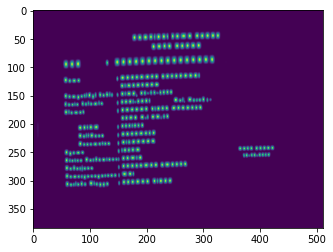

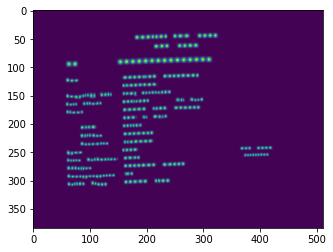

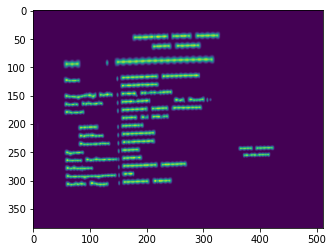

In [69]:
plt.imshow(score_text);plt.show()
plt.imshow(score_link);plt.show()
plt.imshow(score_text+score_link);plt.show()

-2.0111731843575598


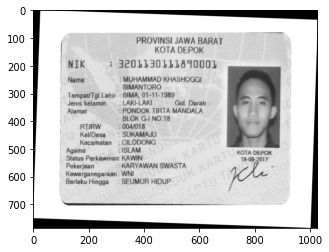

In [70]:
# image = io.imread('input.png')
# grayscale = rgb2gray(image)
angle = determine_skew(score_text+score_link)
rotated = rotate(img, angle, resize=True)
# io.imsave('output.png', rotated.astype(np.uint8))

plt.imshow(rotated)
img=rotated
print(angle)

In [72]:
boxes_list = box_ops.batch_box_coordinate_to_xyminmax(boxes, to_int=True).tolist()   
boxes_list[0]

[566.0, 72.0, 664.0, 106.0]

In [84]:
# import numpy as np
# boxes_proc = np.array(boxes_list)
# xmin, ymin = np.min(boxes_proc[:, 0]), np.min(boxes_proc[:, 1])
# xmax, ymax = np.max(boxes_proc[:, 2]), np.max(boxes_proc[:, 3])

# xmin, ymin, xmax, ymax

In [74]:
# !pip install deskew

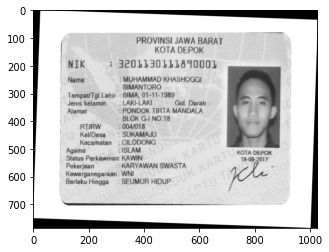

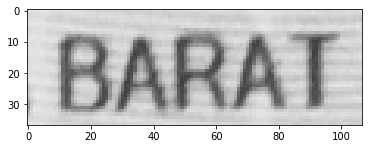

[566.0, 72.0, 664.0, 106.0]


In [75]:
idx = 0
plt.imshow(img);plt.show()
plt.imshow(images_patch[idx]);plt.show()
print(boxes_list[idx])

In [77]:
%%time
text_list = text_pred.predict(images_patch)

CPU times: user 6.07 s, sys: 3.24 ms, total: 6.07 s
Wall time: 779 ms


In [78]:
text_list

['LBBRAT',
 'JAWA',
 'PROVINSI',
 'DEPOK',
 'KOTA',
 '3201130111890001',
 'NIKT',
 'UK',
 'KHASHOGGI',
 'MUHAMMADI',
 'aw',
 'Nama',
 'BIMANTORO',
 '01-11-1989',
 'BIMA,',
 'Lahir',
 'Tempat/Tgli',
 'FAX',
 'Darah',
 'Gol.K',
 'LAKI-LAKI',
 'axk',
 '--K',
 'Kelamin',
 'S.',
 'Jenis',
 'MANDALA',
 'TIRTA',
 'PONDOK',
 'Sa',
 'Alamat',
 'NO.18',
 'G12',
 'BLOK',
 '004/018',
 'RT/RW',
 'LE',
 'SUKAMAJU',
 'Kel/Desa',
 'S.',
 'CILODONG',
 'Kecamatan',
 'EX',
 'DEPOK',
 'KOTA',
 'ISLAM',
 '&.',
 'Agama',
 '19-09-2017',
 'KAWIN',
 'Perkawinan',
 'Status',
 'a.',
 'LSWASTA',
 'KARYAWAN',
 'SAB',
 'Pekerjaan',
 'WNIT',
 'Kewarganegaraan',
 'S.',
 'HIDUP',
 'SEUMUR',
 'Hingga-',
 '--',
 'Berlaku']

In [79]:
data_annoset = text_utils.build_annoset(text_list, boxes)
data_annoset = sorted(data_annoset, key = lambda i: (i['bbox'][1], i['bbox'][0]))

In [80]:
# data_annoset

In [81]:
data, clean = extract.predict(data_annoset)

In [82]:
data

{'provinsi': 'PROVINSI JAWA',
 'kabupaten': 'KOTA DEPOK',
 'nik': '3201130111890001',
 'nama': 'LBBRAT MUHAMMADI KHASHOGGI BIMANTORO LSWASTA',
 'ttl': 'BIMA, 01-11-1989',
 'gender': 'LAKI-LAKI',
 'goldar': '--K',
 'alamat': 'Sa PONDOK BLOK G12 TIRTA NO.18 MANDALA',
 'rtrw': '004/018',
 'kelurahan': 'SUKAMAJU CILODONG',
 'kecamatan': '',
 'agama': 'ISLAM',
 'perkawinan': 'KAWIN',
 'pekerjaan': 'KARYAWAN',
 'kewarganegaraan': 'WNIT',
 'berlaku': 'SEUMUR HIDUP',
 'sign_place': 'KOTA DEPOK',
 'sign_date': '19-09-2017'}

In [83]:
pd.set_option("max_rows", None)
pd.DataFrame(clean)

,words,bboxes,tokens,labels,gseq,wseq
0,LBBRAT,"[566.0, 72.0, 664.0, 106.0]",lb,I-VAL_NAMA,0,0
1,LBBRAT,"[566.0, 72.0, 664.0, 106.0]",##br,I-VAL_NAMA,0,1
2,LBBRAT,"[566.0, 72.0, 664.0, 106.0]",##at,L-VAL_PROV,0,2
3,JAWA,"[483.0, 77.0, 564.0, 105.0]",jawa,B-VAL_PROV,1,0
4,PROVINSI,"[345.0, 81.0, 482.0, 108.0]",provinsi,U-FLD_PROV,2,0
5,DEPOK,"[494.0, 108.0, 596.0, 142.0]",depok,U-VAL_KAB,3,0
6,KOTA,"[413.0, 112.0, 494.0, 141.0]",kota,U-FLD_KAB,4,0
7,3201130111890001,"[281.0, 162.0, 644.0, 191.0]",320,B-VAL_NIK,5,0
8,3201130111890001,"[281.0, 162.0, 644.0, 191.0]",##113,I-VAL_NIK,5,1
9,3201130111890001,"[281.0, 162.0, 644.0, 191.0]",##01,I-VAL_NIK,5,2


In [ ]:
trans